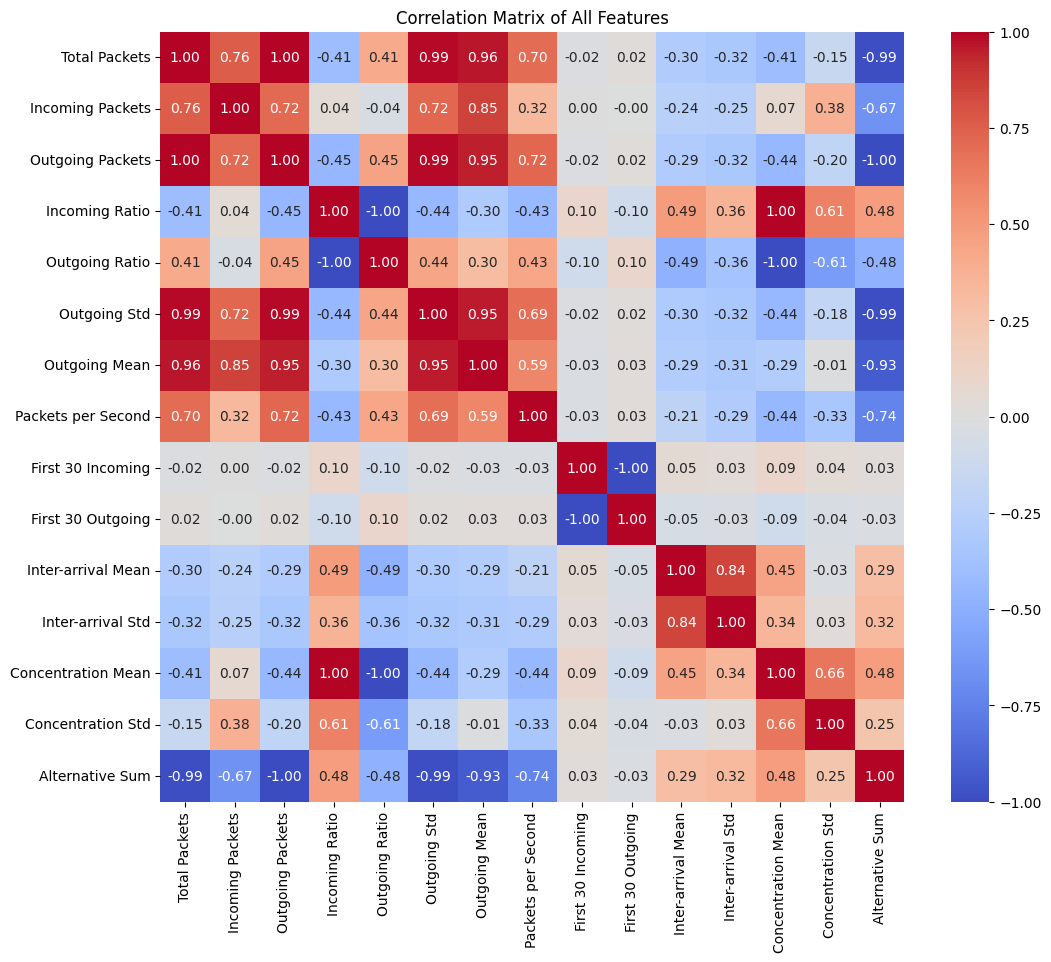

High Correlation Feature Pairs (threshold = 0.8 ):
Total Packets and Outgoing Packets with correlation 1.00
Total Packets and Outgoing Std with correlation 0.99
Total Packets and Outgoing Mean with correlation 0.96
Total Packets and Alternative Sum with correlation -0.99
Incoming Packets and Outgoing Mean with correlation 0.85
Outgoing Packets and Total Packets with correlation 1.00
Outgoing Packets and Outgoing Std with correlation 0.99
Outgoing Packets and Outgoing Mean with correlation 0.95
Outgoing Packets and Alternative Sum with correlation -1.00
Incoming Ratio and Outgoing Ratio with correlation -1.00
Incoming Ratio and Concentration Mean with correlation 1.00
Outgoing Ratio and Incoming Ratio with correlation -1.00
Outgoing Ratio and Concentration Mean with correlation -1.00
Outgoing Std and Total Packets with correlation 0.99
Outgoing Std and Outgoing Packets with correlation 0.99
Outgoing Std and Outgoing Mean with correlation 0.95
Outgoing Std and Alternative Sum with correl

KeyboardInterrupt: 

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv("../../../mon.csv")

# 특성과 레이블 분리
X = data.drop(columns=['Label'])  # 'Label'이 레이블 컬럼 이름
y = data['Label']

# 상관관계 계산
correlation_matrix = X.corr()

# 상관관계 행렬 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of All Features")
plt.show()

# 임계값 설정 (예: 절대 상관계수가 0.8 이상인 특징 쌍만 찾음)
threshold = 0.8

# 상관계수가 threshold 이상인 특징 쌍 찾기 (자기 자신 제외)
high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns 
                   if i != j and abs(correlation_matrix.loc[i, j]) >= threshold]

# 고 상관관계 특징 쌍 출력
print("High Correlation Feature Pairs (threshold =", threshold, "):")
for i, j in high_corr_pairs:
    print(f"{i} and {j} with correlation {correlation_matrix.loc[i, j]:.2f}")

# 상관관계가 높은 특징 조합으로 새로운 특징 생성 (예: 곱과 비율)
for i, j in high_corr_pairs:
    # 곱과 비율을 새로운 특징으로 추가
    X[f'{i}_times_{j}'] = X[i] * X[j]
    X[f'{i}_div_{j}'] = X[i] / (X[j] + 1e-5)  # 0으로 나누는 것을 방지하기 위해 작은 값 추가

# 생성된 조합 특징 포함한 데이터 출력
print("\nNew Features Added Based on High Correlation Pairs:")
print(X.head())

# Train, Validation, Test 데이터 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Neural Network 모델 정의
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(95, activation='softmax')  # 95개의 클래스로 분류하기 위한 출력층
])

# 모델 컴파일 (학습률 조정)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 조기 종료 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# 예측 및 F1 Score 계산
y_pred = np.argmax(model.predict(X_test), axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.2f}")

# 자세한 분류 보고서 출력
print(classification_report(y_test, y_pred))
